# Simulation Guideline

In [1]:
import sys
import os
import time
import pickle
import numpy as np
from numpy.linalg import norm, svd, solve, qr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
import networkx as nx

import scipy
from scipy.sparse import csr_matrix
from scipy.optimize import linear_sum_assignment

import cvxpy as cp
from cvxpy import Variable
from cvxpy.problems.objective import Minimize
from cvxpy.problems.problem import Problem

sys.path.append("./pycvxcluster/")
import pycvxcluster.pycvxcluster

from SpLSI import generate_topic_model as gen_model
from SpLSI.utils import *
from SpLSI.spatialSVD import *
from SpLSI import splsi
import utils.spatial_lda.model
from simulation.simulation_helpers import run_simul, plot_one_simul, plot_fold_cv

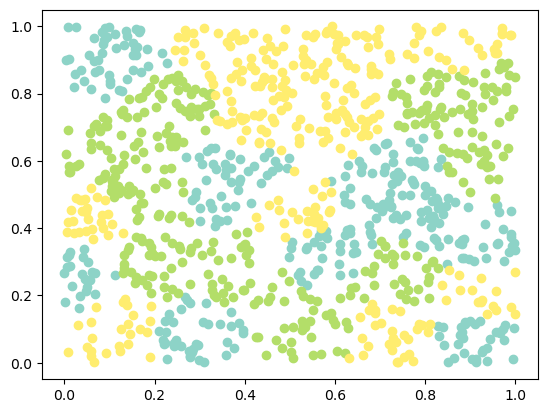

In [2]:
N = 100  # doc length
n = 1000  # number of nodes
p = 30  # vocab size
K = 3  # number of topics
r = 0.05  # heterogeneity parameter
m = 5  # number of neighbors to be considered in weights
phi = 0.1  # weight parameter
coord_df, W, A, D = gen_model.generate_data(N, n, p, K, r)
weights, edge_df = gen_model.generate_weights_edge(coord_df, m, phi)

gen_model.plot_scatter(coord_df)

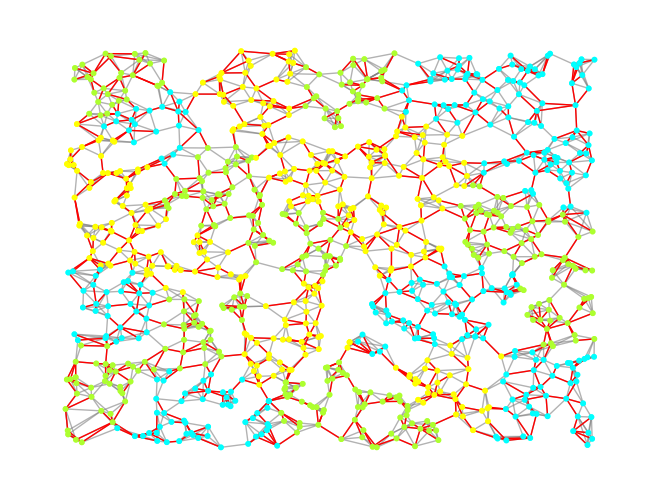

In [27]:
G, mst = get_mst(edge_df)
srn, fold1, fold2 = get_folds(mst)
folds = {0: fold1, 1: fold2}
colors = gen_model.get_colors(coord_df)
colors = [colors[node] for node in G.nodes]

# Plot the random graph
pos_dict = {node: (coord_df["x"][node], coord_df["y"][node]) for node in G.nodes}
nx.set_node_attributes(G, pos_dict, "pos")
pos = nx.get_node_attributes(G, "pos")
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=10,
    node_color=colors,
    edge_color="gray",
    alpha=0.6,
)

# Plot the minimum spanning tree in red
nx.draw(
    mst,
    pos,
    with_labels=False,
    node_size=10,
    node_color=colors,
    edge_color="r",
    alpha=1,
)

plt.show()

## Run Simulation (VanillaSVD / SpatialSVD/ SLDA)

In [3]:
results = run_simul(
    nsim=1, N=100, n=1000, K=3, p=30, start_seed=500
)

Running trial 0...
Running spatial SVD...
starting update_U_tilde...
Starting lambda_search..
Starting cvxcluster...
Starting cvxcluster...


/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


lambda_search Finished


/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


starting update_U_tilde...
Starting lambda_search..
Starting cvxcluster...
Starting cvxcluster...


/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Desktop/SpLSI/./pycvxcluster/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


lambda_search Finished
SpatialSVD ran for 2 steps.
Running SPOC...
CV Lambda is 0.012839184645488633
Runing SLDA...
Running vanilla SVD...
Running SPOC...


In [4]:
results

,trial,seed,regens,N,n,p,K,plsi_err,plsi_l1_err,plsi_acc,...,splsi_l1_err,splsi_acc,slda_err,slda_l1_err,slda_acc,plsi_time,splsi_time,slda_time,spatial_lambd,splsi_iters
0,0,500,0,100,1000,30,3,7.345061,317.535569,0.805,...,174.123154,0.864,17.256394,774.772075,0.433,0.033313,15.871517,60.325023,0.012839,2


In [4]:
with open("sim_all_cv_mean_interpolation_5.pkl", "wb") as handle:
    pickle.dump(results, handle, protocol=4)

In [14]:
res_df = pd.DataFrame(results)
res_df.to_csv("sim_all_cv_mean_interpolation_5.csv")

## CV Scree Plot in the last iteration of Spatial SVD

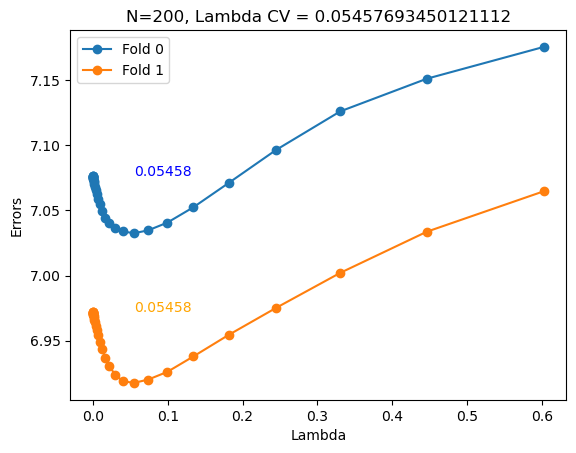

In [7]:
model = results[2]["model_splsi"]
plot_fold_cv(0.0001, 1.35, 30, model, 200)

## Plot error / accuracy / time

[Text(0.5, 1.0, 'N vs Accuracy')]

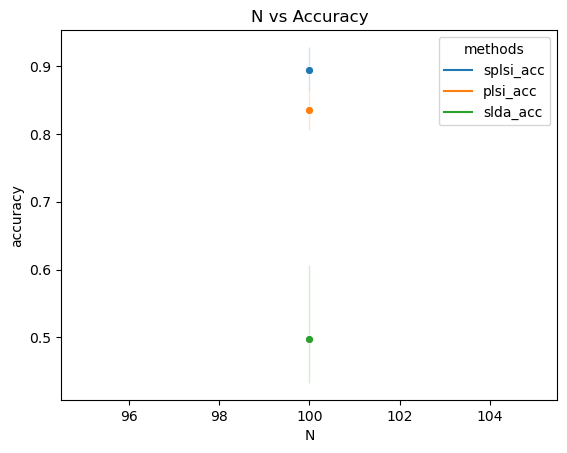

In [5]:
df = pd.DataFrame(results)
df_melted = pd.melt(
    df[["splsi_acc", "plsi_acc", "slda_acc", "N"]],
    id_vars="N",
    var_name="methods",
    value_name="accuracy",
)
sns.lineplot(x="N", y="accuracy", hue="methods", data=df_melted, marker="o").set(
    title="N vs Accuracy"
)

[Text(0.5, 1.0, 'N vs Time')]

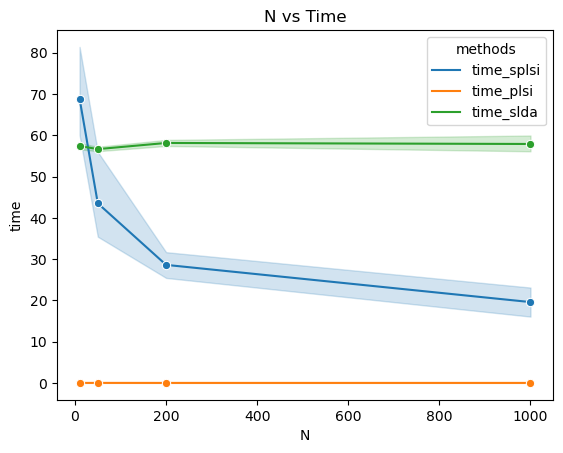

In [22]:
df_melted = pd.melt(
    df[["time_splsi", "time_plsi", "time_slda", "N"]],
    id_vars="N",
    var_name="methods",
    value_name="time",
)
sns.lineplot(x="N", y="time", hue="methods", data=df_melted, marker="o").set(
    title="N vs Time"
)

[Text(0.5, 1.0, 'N vs Lambda CV')]

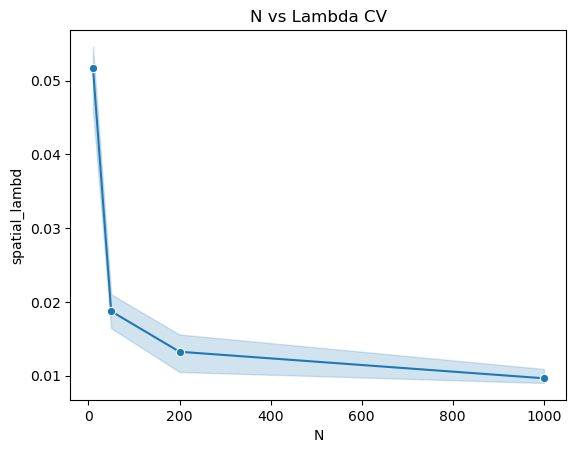

In [13]:
sns.lineplot(x="N", y="spatial_lambd", data=df, marker="o").set(title="N vs Lambda CV")